In [1]:
import sys
sys.path.append('..')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import taiko as tk
from taiko.tools.config import *
from taiko.play import get_play, get_similarity
from taiko.database import load_record_df
from taiko.performance import get_performance, get_pf_similarity

from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import posixpath
import multiprocessing
from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.5)

Using TensorFlow backend.


In [3]:
SONG_ID = 1

In [4]:
record_df = load_record_df(song_id=SONG_ID)
record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime
1,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05
5,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13
9,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41
13,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23
25,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16
29,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10
33,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26
37,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11
42,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21
46,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57


In [5]:
play_result_df = pd.read_csv(PLAY_RESULT_TABLE_PATH)
play_result_df.drop(['drummer_name', 'song_id', 'capture_datetime'], axis=1, inplace=True)
play_record_df = record_df.merge(play_result_df, left_index=True, right_on='id', how='inner')
play_record_df['note'] = play_record_df['good'] + play_record_df['ok'] + play_record_df['bad']
play_record_df = play_record_df[play_record_df['note'] == ALL_NOTE_COUNT_DICT[SONG_ID]]
play_record_df.drop('note', axis=1, inplace=True)
play_record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
16,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16,25,1,792630,54,30,2,84,42
20,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10,29,2,803450,57,25,4,61,48
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,64
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,65


In [6]:
full_combo_df = play_record_df[play_record_df['bad'] == 0]
full_combo_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,64
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,65
38,celiven,1,L_2018-09-22_144040.csv,R_2018-09-22_144039.csv,capture_2018_09_22_14_40_39,50,3,989460,84,2,0,86,64
41,celiven,1,L_2018-09-22_145139.csv,R_2018-09-22_145139.csv,capture_2018_09_22_14_51_38,54,4,999560,86,0,0,86,61


In [7]:
# test
# CONSIDERED_IDS = [61, 150]

# doraemon individual
# CONSIDERED_IDS = [1, 33, 61, 99, 150, 180, 241, 254, 288, 323]

# doraemon individual for two occurance
CONSIDERED_IDS = [1, 5, 33, 37, 60, 64, 98, 106, 140, 149, 179, 180, 240, 248, 253, 257, 287, 309, 322, 326]

# RPG individual for two occurance
# CONSIDERED_IDS = [10, 14, 52, 56, 79, 83, 121, 125, 155, 159, 208, 216, 280, 284, 311, 315, 350, 354]

# all
# CONSIDERED_IDS = play_record_df['id'].values

# full_combo
# CONSIDERED_IDS = full_combo_df['id'].values

CONSIDERED_IDS

[1,
 5,
 33,
 37,
 60,
 64,
 98,
 106,
 140,
 149,
 179,
 180,
 240,
 248,
 253,
 257,
 287,
 309,
 322,
 326]

In [8]:
def plot_similarity_heatmap(dtw_df):
    vis_right_df = play_record_df.copy()
    vis_right_df = vis_right_df[['drummer_name', 'id']]

    vis_df = dtw_df.merge(vis_right_df, left_on='a_id', right_on='id', how='inner')
    vis_df = vis_df.merge(vis_right_df, left_on='b_id', right_on='id', how='inner')
    vis_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
    vis_df = vis_df.rename(index=str, columns={'drummer_name_x': 'a_drummer_name',
                                      'drummer_name_y': 'b_drummer_name'})
    vis_df['a_id'] = vis_df['a_id'].apply(str)
    vis_df['b_id'] = vis_df['b_id'].apply(str)
    vis_df['play1'] = vis_df[['a_drummer_name', 'a_id']].apply(lambda x: '-'.join(x), axis=1)
    vis_df['play2'] = vis_df[['b_drummer_name', 'b_id']].apply(lambda x: '-'.join(x), axis=1)
    vis_df = vis_df.pivot('play1', 'play2', 'norm_sim')
    plt.figure(figsize=(15, 15))
    ax = sns.heatmap(vis_df, annot=True, fmt='.1f')

# raw merge

In [56]:
dtw_df = pd.read_csv('dtw_df@cosine_doraemon.csv')
dtw_df

,a_id,b_id,acc_dtw,gyr_dtw
0,1,5,373.248225,333.992299
1,1,33,645.395708,566.888949
2,1,37,669.615469,628.354249
3,1,60,693.101204,555.258791
4,1,64,735.619436,474.527276
5,1,98,728.652581,661.723001
6,1,106,649.984218,814.481692
7,1,140,645.323149,647.320292
8,1,149,780.134608,716.896441
9,1,179,873.044633,771.337398


In [57]:
dtw_df['acc_dtw'].corr(dtw_df['gyr_dtw'])

0.48189070049767824

In [58]:
SIMILARITY_COLUMNS = list(dtw_df.drop(['a_id', 'b_id'], axis=1).columns)
SIMILARITY_COLUMNS

['acc_dtw', 'gyr_dtw']

/usr/bin/anaconda3/envs/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


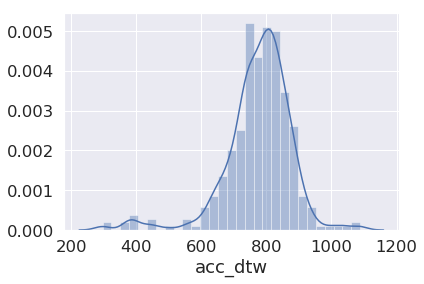

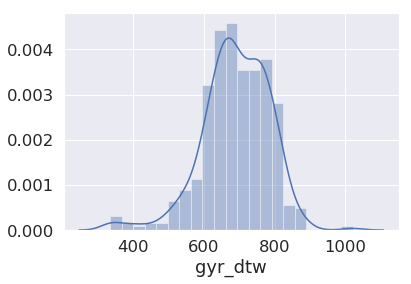

In [59]:
for col in SIMILARITY_COLUMNS:
    sns.distplot(dtw_df[col])
    plt.show()

In [60]:
scaler = StandardScaler()
dtw_df[SIMILARITY_COLUMNS] = scaler.fit_transform(dtw_df[SIMILARITY_COLUMNS])
# dtw_df['acc_dtw'] -= dtw_df.min(axis=0)['acc_dtw']
# dtw_df['gyr_dtw'] -= dtw_df.min(axis=0)['gyr_dtw']
dtw_df['norm_sim'] = dtw_df[SIMILARITY_COLUMNS].mean(axis=1)
dtw_df

,a_id,b_id,acc_dtw,gyr_dtw,norm_sim
0,1,5,-3.843923,-3.772929,-3.808426
1,1,33,-1.239286,-1.309706,-1.274496
2,1,37,-1.007486,-0.659620,-0.833553
3,1,60,-0.782712,-1.432712,-1.107712
4,1,64,-0.375783,-2.286566,-1.331174
5,1,98,-0.442461,-0.306697,-0.374579
6,1,106,-1.195371,1.308950,0.056790
7,1,140,-1.239980,-0.459026,-0.849503
8,1,149,0.050258,0.276843,0.163550
9,1,179,0.939470,0.852636,0.896053


In [61]:
dtw_df[dtw_df['a_id'] == 60]

,a_id,b_id,acc_dtw,gyr_dtw,norm_sim
76,60,1,-0.818141,-1.566758,-1.192449
77,60,5,-0.025193,0.968618,0.471712
78,60,33,0.968518,-1.100585,-0.066034
79,60,37,-0.594739,-0.249351,-0.422045
80,60,64,-3.177574,-1.872632,-2.525103
81,60,98,-0.234676,0.560617,0.162970
82,60,106,-0.396667,-0.959027,-0.677847
83,60,140,0.124402,0.609615,0.367008
84,60,149,-0.408820,0.735508,0.163344
85,60,179,0.615219,0.301810,0.458514


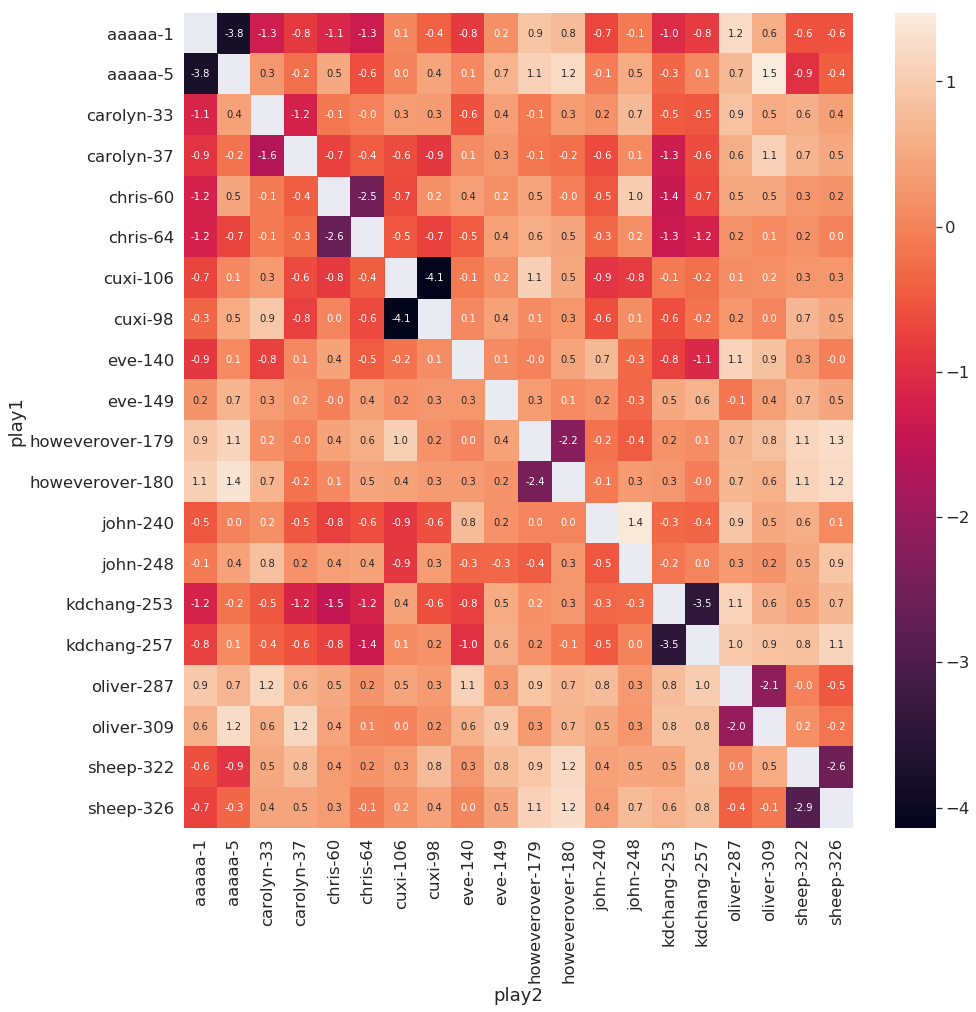

In [62]:
plot_similarity_heatmap(dtw_df)

In [16]:
dtw_df = pd.read_csv('dtw_df@cosine_merge_ex.csv')

scaler = StandardScaler()
dtw_df[SIMILARITY_COLUMNS] = scaler.fit_transform(dtw_df[SIMILARITY_COLUMNS])
for col in SIMILARITY_COLUMNS:
    dtw_df[col] -= dtw_df.min(axis=0)[col]
    
dtw_df['norm_sim'] = np.sqrt(np.square(dtw_df[SIMILARITY_COLUMNS]).sum(axis=1))
dtw_df

,a_id,b_id,acc_dtw,gyr_dtw,norm_sim
0,1,5,0.817408,0.062029,0.819759
1,1,33,3.144899,2.367809,3.936611
2,1,37,3.539888,3.671803,5.100289
3,1,60,3.519383,2.515800,4.326119
4,1,64,3.671361,1.546810,3.983907
5,1,98,4.075349,3.245032,5.209482
6,1,106,3.435716,3.335144,4.788249
7,1,140,3.498548,3.440239,4.906637
8,1,149,4.510013,4.157163,6.133696
9,1,179,5.195214,4.231892,6.700684


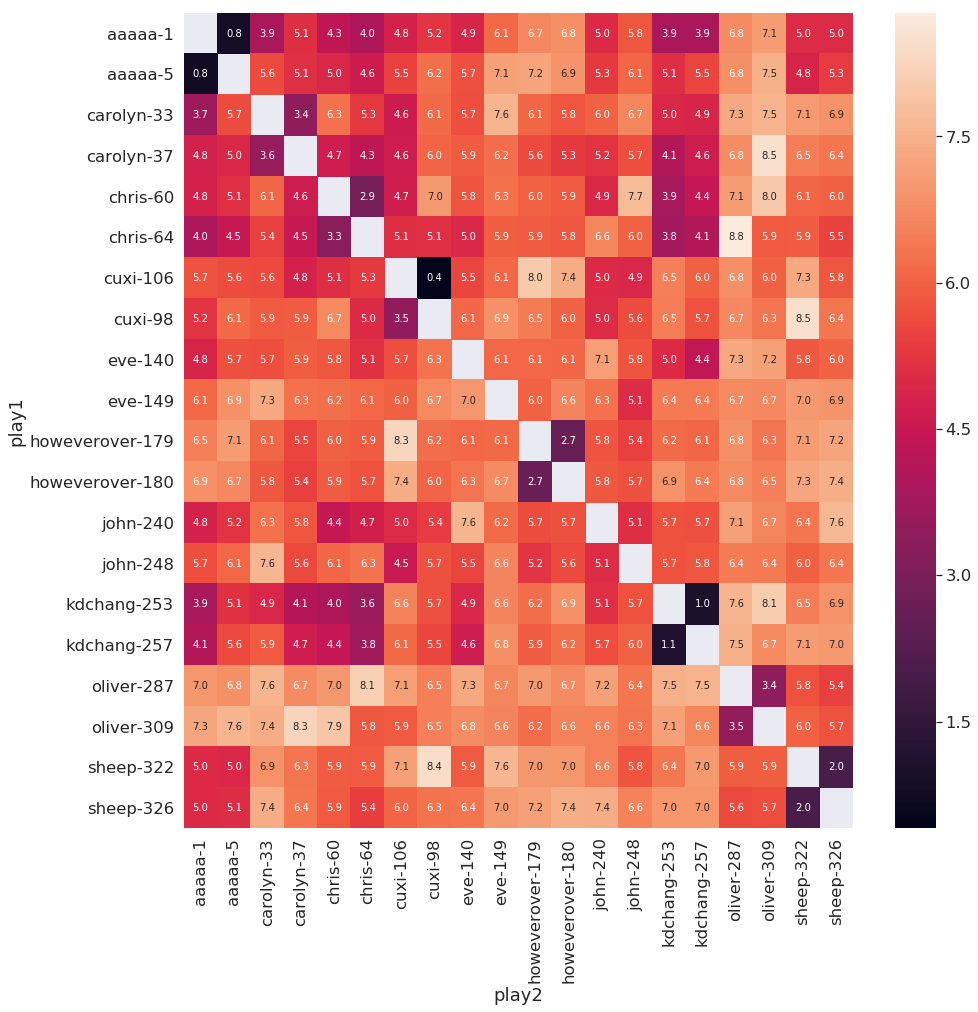

In [17]:
plot_similarity_heatmap(dtw_df)

In [18]:
import lightgbm as lgb
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [19]:
COLL = 'score'
score_right_df = play_record_df.copy()
score_right_df = score_right_df[[COLL, 'id']]

score_df = dtw_df.copy()
score_df = score_df.merge(score_right_df, left_on='a_id', right_on='id', how='inner')
score_df = score_df.merge(score_right_df, left_on='b_id', right_on='id', how='inner')
score_df = score_df[score_df['a_id'] < score_df['b_id']].reset_index(drop=True)
score_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
score_df[COLL + '_dif'] = np.abs(score_df[COLL + '_x'] - score_df[COLL + '_y'])
score_df.drop([COLL + '_x', COLL + '_y'], axis=1, inplace=True)
score_df

,a_id,b_id,acc_dtw,gyr_dtw,norm_sim,score_dif
0,1,5,0.817408,0.062029,0.819759,14250
1,1,33,3.144899,2.367809,3.936611,29550
2,5,33,4.160746,3.760825,5.608531,43800
3,1,37,3.539888,3.671803,5.100289,61150
4,5,37,4.011244,3.171331,5.113455,75400
5,33,37,3.249285,1.057290,3.416975,31600
6,1,60,3.519383,2.515800,4.326119,66880
7,5,60,3.905803,3.045838,4.953021,81130
8,33,60,5.613440,2.798172,6.272198,37330
9,37,60,3.738911,2.785398,4.662392,5730


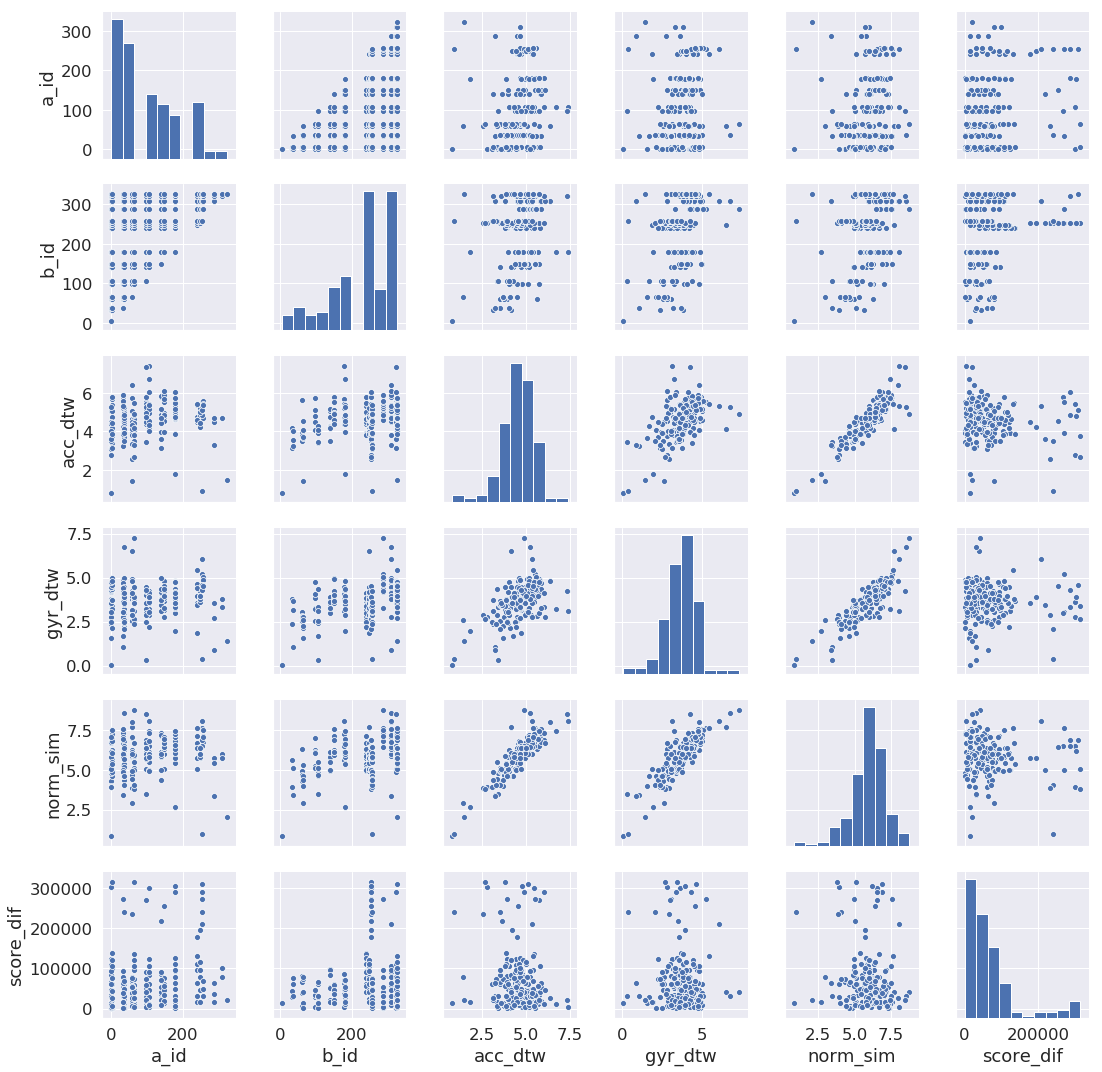

In [20]:
sns.pairplot(data=score_df)

In [21]:
train_df = score_df.drop(['a_id', 'b_id'], axis=1).copy()
x = train_df.drop(COLL + '_dif', axis=1)
y = train_df[COLL + '_dif']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, random_state=0, test_size=0.5)

train_df

,acc_dtw,gyr_dtw,norm_sim,score_dif
0,0.817408,0.062029,0.819759,14250
1,3.144899,2.367809,3.936611,29550
2,4.160746,3.760825,5.608531,43800
3,3.539888,3.671803,5.100289,61150
4,4.011244,3.171331,5.113455,75400
5,3.249285,1.057290,3.416975,31600
6,3.519383,2.515800,4.326119,66880
7,3.905803,3.045838,4.953021,81130
8,5.613440,2.798172,6.272198,37330
9,3.738911,2.785398,4.662392,5730


In [22]:
train_set = lgb.Dataset(x_train, y_train)
valid_set = lgb.Dataset(x_valid, y_valid, free_raw_data=False)
watchlist = [valid_set]

params = dict({
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'application': 'mae',
#     'min_data_in_leaf': 3,
#     'max_depth': 100,
#     'num_leaves': 2 ** 7,
#     'min_data': 1,
    'verbosity': 0,
#     'metric': ['l2']
})

grid_params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [8, 10],
}

model = lgb.train(params, train_set=train_set, valid_sets=watchlist,
                  num_boost_round=2000, verbose_eval=20, early_stopping_rounds=100)
y_pred = model.predict(x_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's l1: 50629.3
[40]	valid_0's l1: 50531.6
[60]	valid_0's l1: 50704.9
[80]	valid_0's l1: 51107.6
[100]	valid_0's l1: 51529.2
[120]	valid_0's l1: 51731.2
Early stopping, best iteration is:
[27]	valid_0's l1: 50503.7


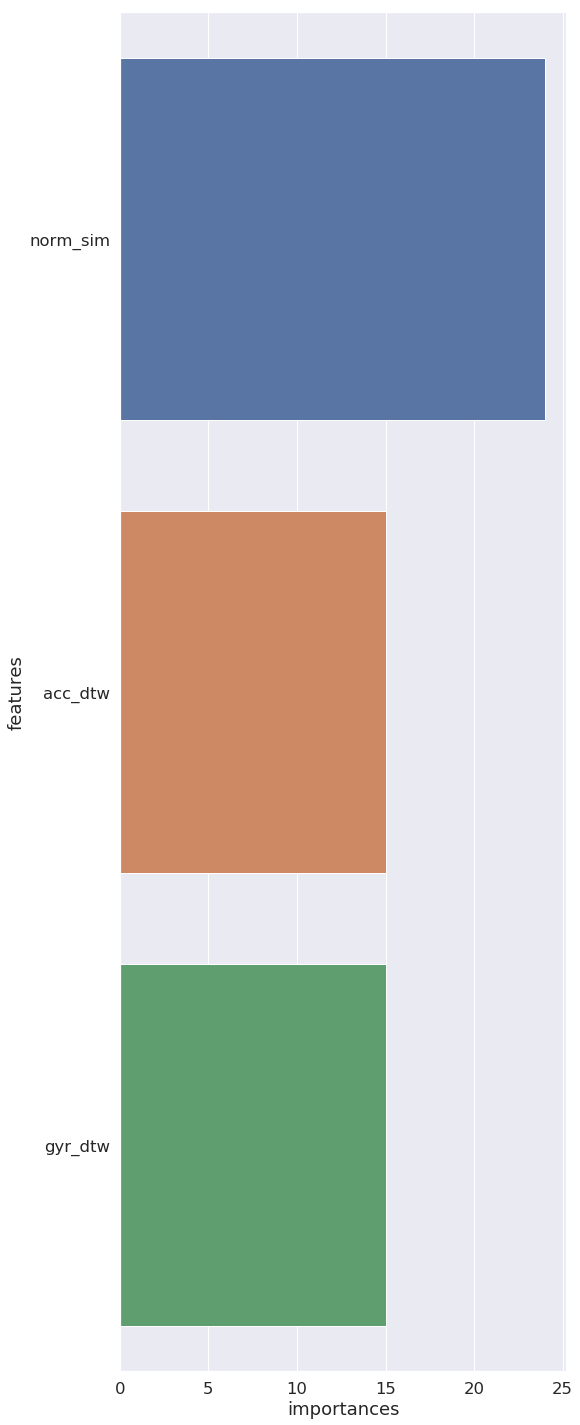

In [23]:
plot_df = pd.DataFrame({'features': train_df.columns[train_df.columns != COLL + '_dif'],
                        'importances': model.feature_importance()})
plot_df = plot_df.sort_values('importances', ascending=False)
plot_df = plot_df.head(30)
plt.figure(figsize=(8, 25))
sns.barplot(x = plot_df.importances, y = plot_df.features)
plt.show()

In [24]:
compare_df = pd.DataFrame(data={
    'pred': y_pred,
    'test': y_test,
})
compare_df['dif'] = np.abs(compare_df['pred'] - compare_df['test'])
compare_df.reset_index(inplace=True)
compare_df

,index,pred,test,dif
0,108,55928.414039,400,55528.414039
1,74,33410.823107,40100,6689.176893
2,161,49648.463616,70450,20801.536384
3,95,55928.414039,234240,178311.585961
4,123,35053.536018,32500,2553.536018
5,71,36434.266362,135700,99265.733638
6,18,50421.228164,28450,21971.228164
7,124,35120.420916,38230,3109.579084
8,143,49648.463616,91010,41361.536384
9,7,55928.414039,81130,25201.585961


In [25]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [26]:
print('The mae of prediction is:', mean_absolute_error(y_test, y_pred))
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
print('The mape of prediction is:', mean_absolute_percentage_error(y_test, y_pred))

The mae of prediction is: 58061.49813676883
The rmse of prediction is: 93667.0652754841
The mape of prediction is: 482.2458008932721
